# 수수료 

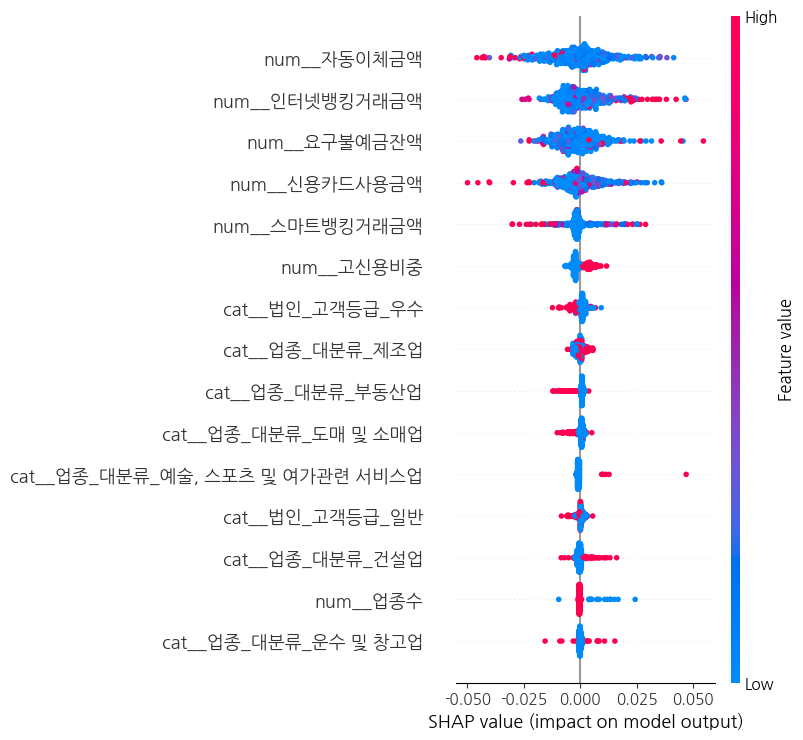

In [5]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# 1. 수수료 수익 타깃 로딩
# -----------------------------
fisis = pd.read_excel("Data/최종 프로젝트/FISIS_MultipleTable_200003-202503.xlsx")

fee_target_df = (
    fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "수수료수익:당분기")]
    .drop(columns=["회사명", "회사코드", "보고서명", "보고서코드", "항목", "factor_id", "단위"])
    .T.rename(columns={fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "수수료수익:당분기")].index[0]: "수수료수익"})
)
fee_target_df.index = pd.to_datetime(fee_target_df.index, format="%Y년%m월")
fee_target_df = fee_target_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})


# -----------------------------
# 2. 입력 데이터 로딩 및 병합
# -----------------------------
df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"], format="%Y%m")

merged = pd.merge(df, fee_target_df, on="기준년월", how="inner").dropna(subset=["수수료수익"])
merged["고객수"] = merged.groupby("기준년월")["법인_고객등급"].transform("count")
merged = merged[merged["고객수"] > 0]

# -----------------------------
# 3. 타깃 및 파생 변수 생성
# -----------------------------
merged["수수료_per고객"] = merged["수수료수익"] / merged["고객수"]
y = np.log1p(merged["수수료_per고객"])

merged["고신용비중"] = (merged["법인_고객등급"] == "최우수").astype(int)
merged["업종수"] = merged.groupby("기준년월")["업종_대분류"].transform("nunique")

# -----------------------------
# 4. 설명변수 선택
# -----------------------------
features = [
    "요구불예금잔액", "자동이체금액", "스마트뱅킹거래금액",
    "인터넷뱅킹거래금액", "신용카드사용금액", "고신용비중", "업종수",
    "법인_고객등급", "업종_대분류"
]
X = merged[features]

# -----------------------------
# 5. 샘플링 및 전처리
# -----------------------------
X_sample = X.sample(n=500, random_state=42)
y_sample = y.loc[X_sample.index]

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# -----------------------------
# 6. XGBoost 모델 학습
# -----------------------------
xgb_model = XGBRegressor(n_estimators=100, max_depth=4, random_state=42)
pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", xgb_model)
])
pipeline.fit(X_sample, y_sample)

# -----------------------------
# 7. SHAP 값 계산 및 시각화
# -----------------------------
X_transformed = preprocessor.transform(X_sample)

explainer = shap.Explainer(
    pipeline.named_steps["model"],
    X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    algorithm="tree"
)
shap_values = explainer(X_transformed)

# 요약 시각화 (summary_plot)
shap.summary_plot(
    shap_values.values,
    features=X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    plot_type="dot",  # 또는 "dot"
    max_display=15
)

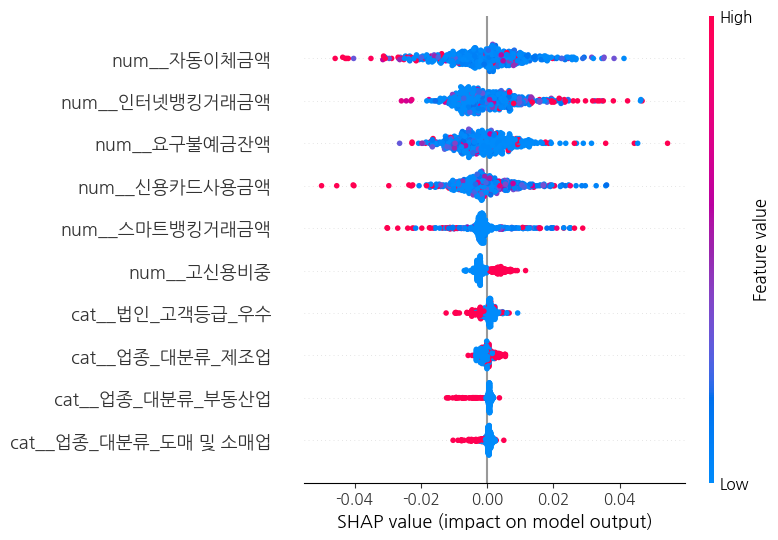

In [4]:
# 요약 시각화 (summary_plot)
shap.summary_plot(
    shap_values.values,
    features=X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    plot_type="dot",  # 또는 "dot"
    max_display=10
)

# 신탁

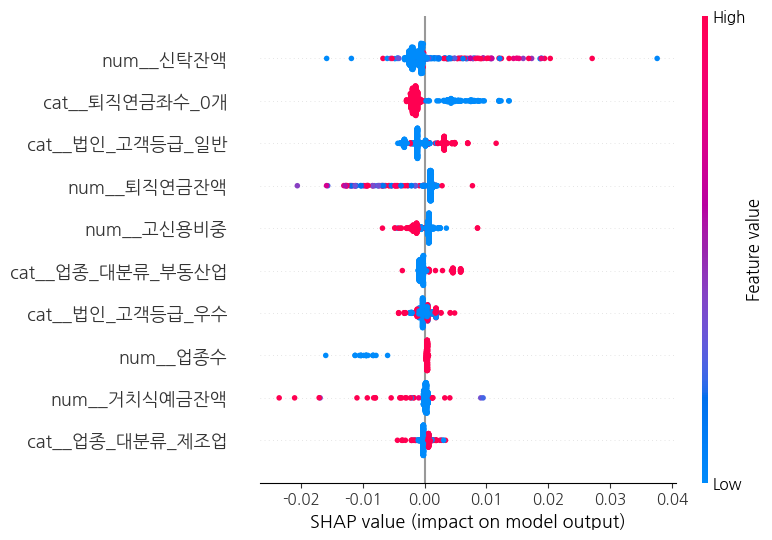

In [6]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# 1. 신탁 수익 타깃 로딩
# -----------------------------
fisis = pd.read_excel("Data/최종 프로젝트/FISIS_MultipleTable_200003-202503.xlsx")
trust_target_df = (
    fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "신탁(은행계정) 관련 손익:당분기")]
    .drop(columns=["회사명", "회사코드", "보고서명", "보고서코드", "항목", "factor_id", "단위"])
    .T.rename(columns={fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "신탁(은행계정) 관련 손익:당분기")].index[0]: "신탁수익"})
)
trust_target_df.index = pd.to_datetime(trust_target_df.index, format="%Y년%m월")
trust_target_df = trust_target_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})

# -----------------------------
# 2. 내부 데이터 병합 및 타깃
# -----------------------------
df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"], format="%Y%m")
merged = pd.merge(df, trust_target_df, on="기준년월", how="inner").dropna(subset=["신탁수익"])
merged["고객수"] = merged.groupby("기준년월")["법인_고객등급"].transform("count")
merged = merged[merged["고객수"] > 0]
merged["신탁_per고객"] = merged["신탁수익"] / merged["고객수"]
y = np.log1p(merged["신탁_per고객"])

# -----------------------------
# 3. 설명변수 정의
# -----------------------------
merged["고신용비중"] = (merged["법인_고객등급"] == "최우수").astype(int)
merged["업종수"] = merged.groupby("기준년월")["업종_대분류"].transform("nunique")

features = [
    "신탁잔액", "퇴직연금잔액", "수익증권잔액", "거치식예금잔액",
    "퇴직연금좌수", "고신용비중", "업종수",
    "법인_고객등급", "업종_대분류"
]
X = merged[features]

# -----------------------------
# 4. 전처리 + 샘플링
# -----------------------------
X_sample = X.sample(n=500, random_state=42)
y_sample = y.loc[X_sample.index]

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

# -----------------------------
# 5. XGBoost 학습 및 SHAP 계산
# -----------------------------
xgb_model = XGBRegressor(n_estimators=100, max_depth=4, random_state=42)
pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", xgb_model)
])
pipeline.fit(X_sample, y_sample)

X_transformed = preprocessor.transform(X_sample)
feature_names = preprocessor.get_feature_names_out()

explainer = shap.Explainer(pipeline.named_steps["model"], X_transformed, 
                           feature_names=feature_names, algorithm="tree")
shap_values = explainer(X_transformed)

# -----------------------------
# 6. SHAP Top10 변수 시각화 (dot plot)
# -----------------------------
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    "변수": feature_names,
    "SHAP 영향력": mean_abs_shap
}).sort_values(by="SHAP 영향력", ascending=False)

top10_features = shap_df["변수"].head(10).tolist()
top10_indices = [i for i, name in enumerate(feature_names) if name in top10_features]

shap.summary_plot(
    shap_values.values[:, top10_indices],
    features=X_transformed[:, top10_indices],
    feature_names=[feature_names[i] for i in top10_indices],
    plot_type="dot"
)

# 유가증권 및 외환부문


▶ 모델: XGBoost
                        변수  SHAP 영향력
4                 num__업종수  0.068585
5          cat__업종_대분류_건설업  0.030282
3               num__고신용비중  0.016745
36         cat__법인_고객등급_일반  0.014263
35         cat__법인_고객등급_우수  0.012803
2              num__수익증권잔액  0.011000
21         cat__업종_대분류_제조업  0.010762
31  cat__ATM거래건수_2건초과 5건이하  0.010540
10    cat__업종_대분류_도매 및 소매업  0.009871
30         cat__ATM거래건수_2건  0.009844

▶ 모델: LightGBM
[LightGBM] [Info] Total Bins 26
[LightGBM] [Info] Number of data points in the train set: 500, number of used features: 13
[LightGBM] [Info] Start training from score 1.192313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

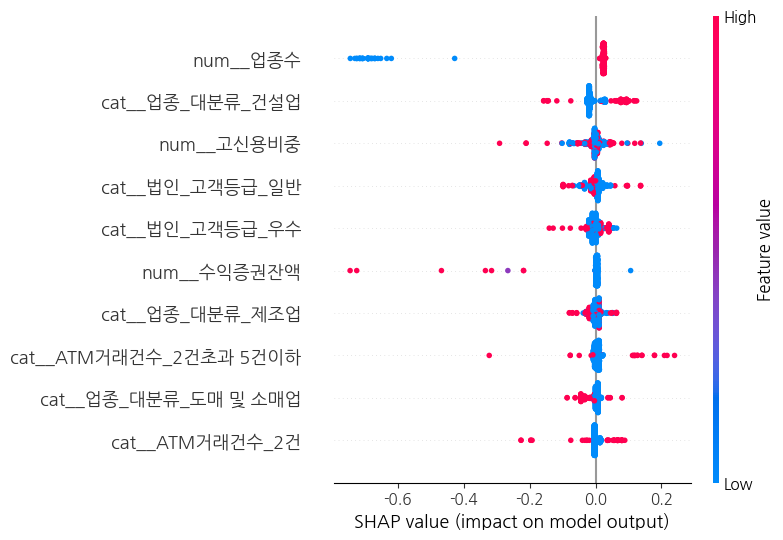

In [28]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# 1. 유가증권+외환 수익 타깃 구성
# -----------------------------
fisis = pd.read_excel("Data/최종 프로젝트/FISIS_MultipleTable_200003-202503.xlsx")

def format_target(df, colname):
    df = df.drop(columns=["회사명", "회사코드", "보고서명", "보고서코드", "항목", "factor_id", "단위"])
    df = df.T
    df.columns = [colname]
    df.index = pd.to_datetime(df.index, format="%Y년%m월")
    return df

sec_income = fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "유가증권 손익:당분기")]
fx_income = fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "외환관련 손익:당분기")]

sec_df = format_target(sec_income, "유가증권수익")
fx_df = format_target(fx_income, "외환수익")

total_df = sec_df.join(fx_df, how="outer").fillna(0)
total_df["유가외환수익"] = total_df["유가증권수익"] + total_df["외환수익"]
total_df = total_df[["유가외환수익"]].resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})

# -----------------------------
# 2. 내부 데이터 불러오기 및 병합
# -----------------------------
df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"], format="%Y%m")

merged = pd.merge(df, total_df, on="기준년월", how="inner").dropna(subset=["유가외환수익"])
merged["고객수"] = merged.groupby("기준년월")["법인_고객등급"].transform("count")
merged = merged[merged["고객수"] > 0]

merged["유가외환_per고객"] = merged["유가외환수익"] / merged["고객수"]
merged = merged[merged["유가외환_per고객"] > 0].dropna(subset=["유가외환_per고객"])
y = np.log1p(merged["유가외환_per고객"])

# -----------------------------
# 3. 설명변수 정의
# -----------------------------
merged["고신용비중"] = (merged["법인_고객등급"] == "최우수").astype(int)
merged["업종수"] = merged.groupby("기준년월")["업종_대분류"].transform("nunique")

features = [
    "외환_수출실적금액", "외환_수입실적금액", 
    "외환_수출실적거래건수", "외환_수입실적거래건수",
    "수익증권좌수", "수익증권잔액", "ATM거래건수",
    "고신용비중", "업종수",
    "법인_고객등급", "업종_대분류"
]
X = merged[features]

# -----------------------------
# 4. SHAP용 샘플 축소
# -----------------------------
X_sample = X.sample(n=500, random_state=42)
y_sample = y.loc[X_sample.index]

# -----------------------------
# 5. 전처리 정의
# -----------------------------
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)  # <- 이 부분 수정
])

# -----------------------------
# 6. 모델 학습 및 SHAP 분석
# -----------------------------
models = {
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=4, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=100, max_depth=4, random_state=42, force_col_wise=True),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
}

top_features = {}

for name, model in models.items():
    print(f"\n▶ 모델: {name}")
    
    pipeline = Pipeline([
        ("prep", preprocessor),
        ("model", model)
    ])
    
    pipeline.fit(X_sample, y_sample)
    
    X_transformed = preprocessor.fit_transform(X_sample)
    explainer = shap.Explainer(pipeline.named_steps["model"], X_transformed, feature_names=preprocessor.get_feature_names_out(), algorithm="tree")
    shap_values = explainer(X_transformed)

    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    shap_df = pd.DataFrame({
        "변수": preprocessor.get_feature_names_out(),
        "SHAP 영향력": mean_abs_shap
    }).sort_values(by="SHAP 영향력", ascending=False)

    print(shap_df.head(10))
    top_features[name] = shap_df["변수"].head(10).tolist()

# -----------------------------
# 7. 변수 일치도 비교 출력
# -----------------------------
print("\n🔍 모델 간 SHAP Top10 변수 일치도")

xgb_set = set(top_features["XGBoost"])
lgb_set = set(top_features["LightGBM"])
rf_set = set(top_features["RandomForest"])

# -----------------------------
# 8. 세 모델 중 2개 이상에서 등장한 변수만 필터링 후 summary_plot
# -----------------------------
from collections import Counter

# 모든 Top10 변수 모아서 등장 횟수 계산
all_top_vars = top_features["XGBoost"] + top_features["LightGBM"] + top_features["RandomForest"]
var_counter = Counter(all_top_vars)

# 2개 이상 모델에 등장한 변수만 추출
shared_vars = [var for var, count in var_counter.items() if count >= 2]

print("\n✅ 2개 이상 모델에 공통 등장한 주요 변수:")
print(shared_vars)

# XGBoost 기준 SHAP 값과 전처리된 feature matrix
X_transformed = preprocessor.fit_transform(X_sample)
explainer = shap.Explainer(models["XGBoost"], X_transformed, feature_names=preprocessor.get_feature_names_out(), algorithm="tree")
shap_values = explainer(X_transformed)

# 해당 변수만 선택하여 summary_plot 실행
all_feature_names = preprocessor.get_feature_names_out()
selected_indices = [i for i, name in enumerate(all_feature_names) if name in shared_vars]

shap.summary_plot(
    shap_values.values[:, selected_indices],
    features=X_transformed[:, selected_indices],
    feature_names=[all_feature_names[i] for i in selected_indices],
    plot_type="dot"
)


# 외환

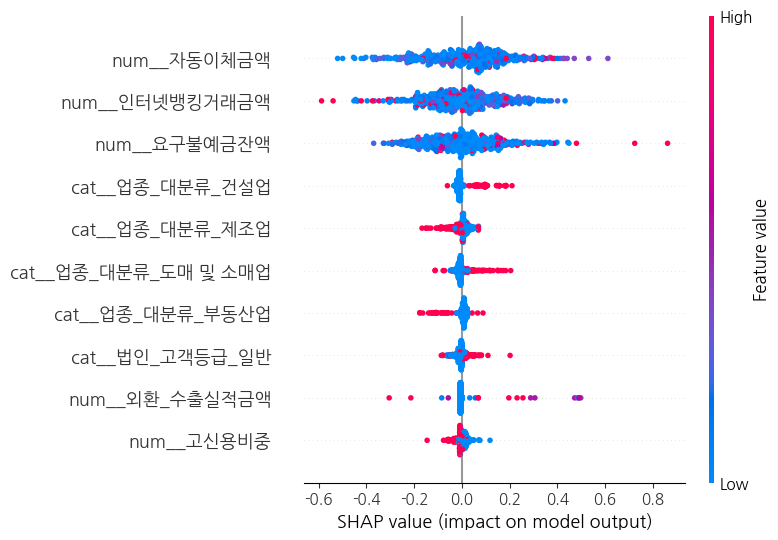

In [9]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# 데이터 불러오기
# -----------------------------
fisis = pd.read_excel("Data/최종 프로젝트/FISIS_MultipleTable_200003-202503.xlsx")
df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"], format="%Y%m")

# -----------------------------
# 외환수익 타깃 구성
# -----------------------------
def format_target(df, colname):
    df = df.drop(columns=["회사명", "회사코드", "보고서명", "보고서코드", "항목", "factor_id", "단위"])
    df = df.T
    df.columns = [colname]
    df.index = pd.to_datetime(df.index, format="%Y년%m월")
    return df

fx_income = fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "외환관련 손익:당분기")]
fx_df = format_target(fx_income, "외환수익")
fx_df = fx_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})

merged_fx = pd.merge(df, fx_df, on="기준년월", how="inner").dropna(subset=["외환수익"])
merged_fx["고객수"] = merged_fx.groupby("기준년월")["법인_고객등급"].transform("count")
merged_fx = merged_fx[merged_fx["고객수"] > 0]
merged_fx["외환_per고객"] = merged_fx["외환수익"] / merged_fx["고객수"]
merged_fx = merged_fx[merged_fx["외환_per고객"] > 0].dropna(subset=["외환_per고객"])
y_fx = np.log1p(merged_fx["외환_per고객"])

# -----------------------------
# 설명변수 정의
# -----------------------------
merged_fx["고신용비중"] = (merged_fx["법인_고객등급"] == "최우수").astype(int)
merged_fx["업종수"] = merged_fx.groupby("기준년월")["업종_대분류"].transform("nunique")

X_fx = merged_fx[
    [
        "외환_수출실적금액", "외환_수입실적금액",
        "외환_수출실적거래건수", "외환_수입실적거래건수",
        "요구불예금잔액", "자동이체금액", "인터넷뱅킹거래금액",
        "고신용비중", "업종수", "법인_고객등급", "업종_대분류"
    ]
]

# -----------------------------
# 전처리 + XGBoost + SHAP
# -----------------------------
X_sample = X_fx.sample(n=500, random_state=42)
y_sample = y_fx.loc[X_sample.index]

num_cols = X_sample.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X_sample.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", XGBRegressor(n_estimators=100, max_depth=4, random_state=42))
])

pipeline.fit(X_sample, y_sample)

X_transformed = preprocessor.fit_transform(X_sample)
explainer = shap.Explainer(
    pipeline.named_steps["model"],
    X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    algorithm="tree"
)
shap_values = explainer(X_transformed)

shap.summary_plot(
    shap_values,
    features=X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    plot_type="dot",
    max_display=10
)

In [13]:
# SHAP 영향도 수치 확인
mean_abs_shap_fx = np.abs(shap_values.values).mean(axis=0)
shap_df_fx = pd.DataFrame({
    "변수": preprocessor.get_feature_names_out(),
    "SHAP 영향도": mean_abs_shap_fx
}).sort_values(by="SHAP 영향도", ascending=False)

print("📌 외환수익 SHAP 영향도 Top10")
display(shap_df_fx.head(10))

📌 외환수익 SHAP 영향도 Top10


,변수,SHAP 영향도
3,num__자동이체금액,0.130710
4,num__인터넷뱅킹거래금액,0.114885
2,num__요구불예금잔액,0.111998
10,cat__업종_대분류_건설업,0.024378
25,cat__업종_대분류_제조업,0.022914
14,cat__업종_대분류_도매 및 소매업,0.018996
16,cat__업종_대분류_부동산업,0.015567
8,cat__법인_고객등급_일반,0.015424
0,num__외환_수출실적금액,0.014311
5,num__고신용비중,0.013910


# 유가증권

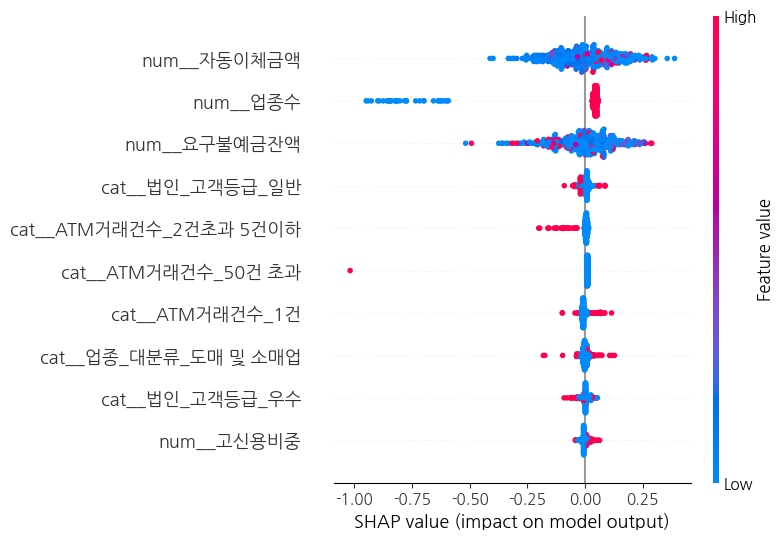

In [15]:
# -----------------------------
# 유가증권수익 타깃 구성
# -----------------------------
sec_income = fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "유가증권 손익:당분기")]
sec_df = format_target(sec_income, "유가증권수익")
sec_df = sec_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})

merged_sec = pd.merge(df, sec_df, on="기준년월", how="inner").dropna(subset=["유가증권수익"])
merged_sec["고객수"] = merged_sec.groupby("기준년월")["법인_고객등급"].transform("count")
merged_sec = merged_sec[merged_sec["고객수"] > 0]
merged_sec["유가_per고객"] = merged_sec["유가증권수익"] / merged_sec["고객수"]
merged_sec = merged_sec[merged_sec["유가_per고객"] > 0].dropna(subset=["유가_per고객"])
y_sec = np.log1p(merged_sec["유가_per고객"])

# -----------------------------
# 설명변수 정의
# -----------------------------
merged_sec["고신용비중"] = (merged_sec["법인_고객등급"] == "최우수").astype(int)
merged_sec["업종수"] = merged_sec.groupby("기준년월")["업종_대분류"].transform("nunique")

X_sec = merged_sec[
    [
        "수익증권잔액", "수익증권좌수", "요구불예금잔액",
        "자동이체금액", "ATM거래건수",
        "고신용비중", "업종수", "법인_고객등급", "업종_대분류"
    ]
]

# -----------------------------
# 전처리 + XGBoost + SHAP
# -----------------------------
X_sample = X_sec.sample(n=500, random_state=42)
y_sample = y_sec.loc[X_sample.index]

num_cols = X_sample.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X_sample.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", XGBRegressor(n_estimators=100, max_depth=4, random_state=42))
])

pipeline.fit(X_sample, y_sample)

X_transformed = preprocessor.fit_transform(X_sample)
explainer = shap.Explainer(
    pipeline.named_steps["model"],
    X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    algorithm="tree"
)
shap_values = explainer(X_transformed)

shap.summary_plot(
    shap_values,
    features=X_transformed,
    feature_names=preprocessor.get_feature_names_out(),
    plot_type="dot",
    max_display=10
)


In [16]:
# SHAP 영향도 수치 확인
mean_abs_shap_sec = np.abs(shap_values.values).mean(axis=0)
shap_df_sec = pd.DataFrame({
    "변수": preprocessor.get_feature_names_out(),
    "SHAP 영향도": mean_abs_shap_sec
}).sort_values(by="SHAP 영향도", ascending=False)

print("📌 유가증권수익 SHAP 영향도 Top10")
display(shap_df_sec.head(10))


📌 유가증권수익 SHAP 영향도 Top10


,변수,SHAP 영향도
2,num__자동이체금액,0.103808
4,num__업종수,0.098678
1,num__요구불예금잔액,0.090037
6,cat__법인_고객등급_일반,0.014012
34,cat__ATM거래건수_2건초과 5건이하,0.012331
37,cat__ATM거래건수_50건 초과,0.012274
31,cat__ATM거래건수_1건,0.011697
16,cat__업종_대분류_도매 및 소매업,0.011234
5,cat__법인_고객등급_우수,0.010670
3,num__고신용비중,0.009810


# 판관비

In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
import warnings
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import shap
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor
import lightgbm as lgb 

warnings.filterwarnings("ignore")

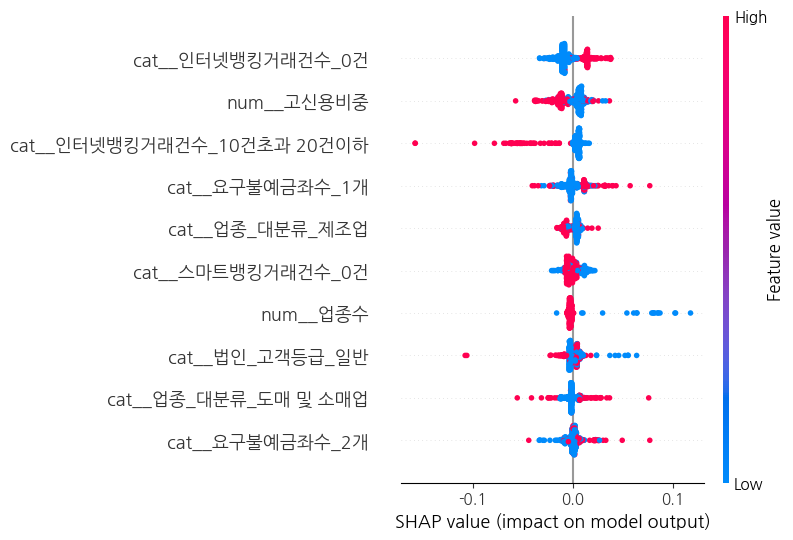

In [17]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

warnings.filterwarnings("ignore")

# -----------------------------
# 1. 데이터 불러오기 및 병합
# -----------------------------
fisis = pd.read_excel("Data/최종 프로젝트/FISIS_MultipleTable_200003-202503.xlsx")
df = pd.read_csv("Data/최종 프로젝트/최종_데이터.csv", encoding="cp949")
df["기준년월"] = pd.to_datetime(df["기준년월"], format="%Y%m")

# 판관비 데이터 전처리
target_df = (
    fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "판매비와 관리비:당분기")]
    .drop(columns=["회사명", "회사코드", "보고서명", "보고서코드", "항목", "factor_id", "단위"])
    .T.rename(columns={fisis[(fisis["회사명"] == "아이엠뱅크") & (fisis["항목"] == "판매비와 관리비:당분기")].index[0]: "판관비"})
)
target_df.index = pd.to_datetime(target_df.index, format="%Y년%m월")
target_df = target_df.resample("MS").interpolate("linear").reset_index().rename(columns={"index": "기준년월"})

# 병합 및 타깃 구성
merged = pd.merge(df, target_df, on="기준년월", how="inner")
merged["고객수"] = merged.groupby("기준년월")["법인_고객등급"].transform("count")
merged = merged[(merged["고객수"] > 0) & (merged["판관비"] > 0)]
merged["판관비_per고객"] = merged["판관비"] / merged["고객수"]
merged = merged[merged["판관비_per고객"] > 0]
y = np.log1p(merged["판관비_per고객"])

# -----------------------------
# 2. 설명변수 설정
# -----------------------------
merged["고신용비중"] = (merged["법인_고객등급"] == "최우수").astype(int)
merged["업종수"] = merged.groupby("기준년월")["업종_대분류"].transform("nunique")

features = [
    "창구거래건수", "인터넷뱅킹거래건수", "스마트뱅킹거래건수",
    "요구불예금좌수", "적립식예금좌수", "거치식예금좌수",
    "고신용비중", "업종수",
    "법인_고객등급", "업종_대분류"
]
X = merged[features]

# -----------------------------
# 3. 전처리 및 샘플링
# -----------------------------
X_sample = X.sample(n=500, random_state=42)
y_sample = y.loc[X_sample.index]

num_cols = X_sample.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(X_sample.columns) - set(num_cols))

preprocessor = ColumnTransformer([
    ("num", MinMaxScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

# -----------------------------
# 4. XGBoost 학습 및 SHAP Top10 시각화
# -----------------------------
pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", XGBRegressor(n_estimators=100, max_depth=4, random_state=42))
])
pipeline.fit(X_sample, y_sample)

X_transformed = preprocessor.fit_transform(X_sample)
feature_names = preprocessor.get_feature_names_out()

explainer = shap.Explainer(
    pipeline.named_steps["model"],
    X_transformed,
    feature_names=feature_names,
    algorithm="tree"
)
shap_values = explainer(X_transformed)

# SHAP 평균 영향도 계산
mean_shap = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    "변수": feature_names,
    "SHAP 영향력": mean_shap
}).sort_values(by="SHAP 영향력", ascending=False)

# Top10 변수 인덱스 추출
top10_vars = shap_df["변수"].head(10).tolist()
top10_indices = [i for i, name in enumerate(feature_names) if name in top10_vars]

# -----------------------------
# 5. SHAP Summary Plot 출력
# -----------------------------
shap.summary_plot(
    shap_values.values[:, top10_indices],
    features=X_transformed[:, top10_indices],
    feature_names=[feature_names[i] for i in top10_indices],
    plot_type="dot"
)

In [20]:
# -----------------------------
# XGBoost 기준 SHAP Top10 영향도 수치 확인
# -----------------------------

# SHAP 평균 영향도 계산
mean_shap = np.abs(shap_values.values).mean(axis=0)

# SHAP 영향도 테이블 생성
shap_df = pd.DataFrame({
    "변수": feature_names,
    "SHAP 영향도": mean_shap
}).sort_values(by="SHAP 영향도", ascending=False)

# Top10 출력
print("📌 XGBoost 기준 판관비 SHAP 영향도 Top10")
display(shap_df.head(10))


📌 XGBoost 기준 판관비 SHAP 영향도 Top10


,변수,SHAP 영향도
31,cat__인터넷뱅킹거래건수_0건,0.011820
0,num__고신용비중,0.009862
32,cat__인터넷뱅킹거래건수_10건초과 20건이하,0.009601
4,cat__요구불예금좌수_1개,0.007262
61,cat__업종_대분류_제조업,0.005070
11,cat__스마트뱅킹거래건수_0건,0.005052
1,num__업종수,0.005045
64,cat__법인_고객등급_일반,0.004973
50,cat__업종_대분류_도매 및 소매업,0.004874
6,cat__요구불예금좌수_2개,0.004344


.   
# ㅇㅇㅇㅇ